# Final project. Part 1. Recommender system A/B testing

**Project background:**

You've received an analytical task from an international on-line store. Your predecessor failed to complete it: they launched an A/B test and then quit (to start a watermelon farm in Brazil). They left only the technical specifications and the test results.

**Technical description of test:**
- Test name: `recommender_system_test`
- Groups: А (control), B (new payment funnel)
- Launch date: 2020-12-07
- The date when they stopped taking up new users: 2020-12-21
- End date: 2021-01-01
- Audience: 15% of the new users from the EU region
- Purpose of the test: testing changes related to the introduction of an improved recommendation system
- Expected result: within 14 days of signing up, users will show better conversion into product page views (the `product_page` event), product card views (`product_card`) and purchases (`purchase`). At each of the stage of the funnel `product_page → product_card → purchase`, there will be at least a 10% increase.
- Expected number of test participants: 6000

**Datasets:**
- `ab_project_marketing_events_us.csv` — the calendar of marketing events for 2020
- `final_ab_new_users_upd.csv` — all users who signed up in the on-line store from December 7 to 21, 2020
- `final_ab_events_upd.csv` — all events of the new users within the period from December 7, 2020 to January 1, 2021
- `final_ab_participants_upd.csv` — table containing test participants

## Downloading data

### Libraries

In [1]:
import pandas as pd
import plotly.express as px
from plotly import graph_objects as go
import math
from scipy import stats

### Marketing events

In [2]:
try:
    marketing = pd.read_csv('ab_project_marketing_events_us.csv')
except:
    marketing = pd.read_csv('/datasets/ab_project_marketing_events_us.csv')

In [3]:
marketing.head()

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11


In [4]:
marketing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes


- `name` — the name of the marketing event
- `regions` — regions where the ad campaign will be held
- `start_dt` — campaign start date
- `finish_dt` — campaign end date

In [5]:
marketing

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11
5,Black Friday Ads Campaign,"EU, CIS, APAC, N.America",2020-11-26,2020-12-01
6,Chinese New Year Promo,APAC,2020-01-25,2020-02-07
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10
9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11


In [6]:
marketing['start_dt']=pd.to_datetime(marketing['start_dt'], format='%Y-%m-%d')

In [7]:
marketing['finish_dt']=pd.to_datetime(marketing['finish_dt'], format='%Y-%m-%d')

### New Users

In [8]:
try:
    users = pd.read_csv('final_ab_new_users_upd_us.csv')
except:
    users = pd.read_csv('/datasets/final_ab_new_users_upd_us.csv')

In [9]:
users.head()

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


In [10]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58703 entries, 0 to 58702
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     58703 non-null  object
 1   first_date  58703 non-null  object
 2   region      58703 non-null  object
 3   device      58703 non-null  object
dtypes: object(4)
memory usage: 1.8+ MB


- `user_id`
- `first_date` — sign-up date
- `region`
- `device` — device used to sign up

In [11]:
users['first_date']=pd.to_datetime(users['first_date'], format='%Y-%m-%d')

In [12]:
users.duplicated().sum()

0

### Participants

In [13]:
try:
    participants = pd.read_csv('final_ab_participants_upd_us.csv')
except:
    participants = pd.read_csv('/datasets/final_ab_participants_upd_us.csv')

In [14]:
participants.head()

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,4FF2998A348C484F,A,recommender_system_test


In [15]:
participants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14525 entries, 0 to 14524
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  14525 non-null  object
 1   group    14525 non-null  object
 2   ab_test  14525 non-null  object
dtypes: object(3)
memory usage: 340.6+ KB


- `user_id`
- `event_dt` — event date and time
- `event_name` — event type name
- `details` — additional data on the event (for instance, the order total in USD for `purchase` events)

In [16]:
participants.duplicated().sum()

0

### Events

In [17]:
try:
    events = pd.read_csv('final_ab_events_upd_us.csv')
except:
    events = pd.read_csv('/datasets/final_ab_events_upd_us.csv')

In [18]:
events.head()

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99


- `user_id`
- `ab_test` — test name
- `group` — the test group the user belonged to

In [19]:
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 423761 entries, 0 to 423760
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     423761 non-null  object 
 1   event_dt    423761 non-null  object 
 2   event_name  423761 non-null  object 
 3   details     60314 non-null   float64
dtypes: float64(1), object(3)
memory usage: 12.9+ MB


In [20]:
events['event_dt']=pd.to_datetime(events['event_dt'], format='%Y-%m-%d %H:%M:%S')

Let's look at the missing values in `details` column:

In [21]:
events[events['details'].isna()]['event_name'].unique()

array(['product_cart', 'product_page', 'login'], dtype=object)

In [22]:
events[(events['details'].isna() & events['event_name'] == "purchase")]

,user_id,event_dt,event_name,details


Missing values in 'details' are only for events other then purchases. Let's fill them with zero:

In [23]:
events['details']=events['details'].fillna(0)

In [24]:
events.duplicated().sum()

0

## Exploratory data analysis

### Marketing events

Let's plot the time-line of marketing events:

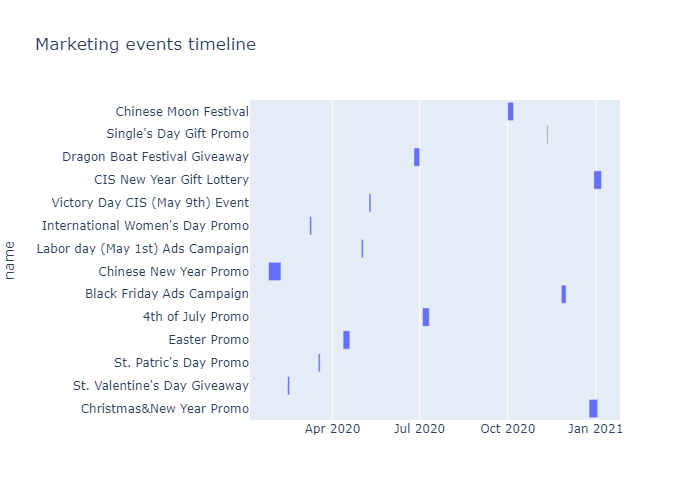

In [25]:
fig = px.timeline(marketing, x_start="start_dt", x_end="finish_dt", y="name", title='Marketing events timeline')
fig.show('png')

Let's add A/B testing period to the graph and zoom it to the period of A/B Testing.

In [26]:
timelines=marketing

In [27]:
timelines.loc[14]=['A/B tesing','EU', '2020-12-07', '2021-01-01']
timelines.loc[14,'start_dt']=pd.to_datetime(timelines.loc[14,'start_dt'], format='%Y-%m-%d')
timelines.loc[14,'finish_dt']=pd.to_datetime(timelines.loc[14,'finish_dt'], format='%Y-%m-%d')

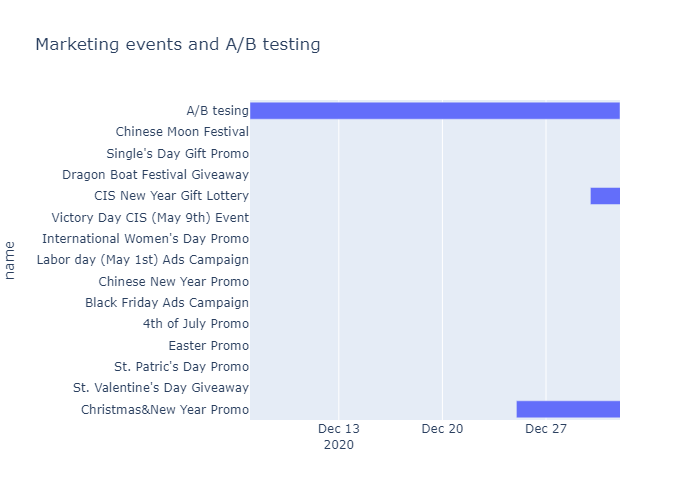

In [28]:
fig = px.timeline(timelines, x_start="start_dt", x_end="finish_dt", y="name", title='Marketing events and A/B testing')
fig.update_xaxes(range=list(['2020-12-07','2021-01-01']))
fig.show('png')

- Two marketing events overlaps with testing period: Christmas&New Year Promo (EU, N.America from 25 December to 3 January) and CIS NewYear Gift Lottery (CIS from 30 December to 7 January).
- The testing period (7 December to 1 January) is most likely affected by seasonal increase in sales (Christmas and New Year holidays).

### Participants

In [29]:
participants['ab_test'].unique()

array(['recommender_system_test', 'interface_eu_test'], dtype=object)

In [30]:
participants.groupby(['ab_test'])['user_id'].nunique()

ab_test
interface_eu_test          10850
recommender_system_test     3675
Name: user_id, dtype: int64

We have participants of two A/B tests in this dataset. We are interested in participants of *recommender_system_test*. 

According to technical description, expected number of test participants is 6000, we have only 3675 participants in recommender_system_test.

In [31]:
participants.groupby(['ab_test','group'])['user_id'].nunique()

ab_test                  group
interface_eu_test        A        5467
                         B        5383
recommender_system_test  A        2747
                         B         928
Name: user_id, dtype: int64

- Number of participants in A and B groups in *interface eu test* is close but difference is still 1.5% (which is above 1%).
- Number of participants in A and B groups in *recommender system test* is significantly uneven: number of B group participants is only 1/3 of number of A group participants.

### Users

In [32]:
users['user_id'].nunique()

58703

In [33]:
users['first_date'].min()

Timestamp('2020-12-07 00:00:00')

In [34]:
users['first_date'].max()

Timestamp('2020-12-23 00:00:00')

In [35]:
users.groupby('first_date')['user_id'].nunique()

first_date
2020-12-07    5291
2020-12-08    3017
2020-12-09    2010
2020-12-10    2784
2020-12-11    2226
2020-12-12    3591
2020-12-13    4181
2020-12-14    5448
2020-12-15    2924
2020-12-16    2093
2020-12-17    2940
2020-12-18    3238
2020-12-19    3480
2020-12-20    4140
2020-12-21    6077
2020-12-22    3083
2020-12-23    2180
Name: user_id, dtype: int64

According to technical description, the date when they stopped taking up new users is 2020-12-21, however we have users signed up on 22 and 23 December.

In [36]:
users.groupby('region')['user_id'].nunique()

region
APAC          3126
CIS           3130
EU           43396
N.America     9051
Name: user_id, dtype: int64

In [37]:
users.groupby('device')['user_id'].nunique()

device
Android    26159
Mac         5797
PC         14845
iPhone     11902
Name: user_id, dtype: int64

### Events

In [38]:
events['user_id'].nunique()

58703

In [39]:
events['date']=events['event_dt'].dt.round('1d')

In [40]:
events.head()

,user_id,event_dt,event_name,details,date
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99,2020-12-08
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99,2020-12-07
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99,2020-12-08
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99,2020-12-07
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99,2020-12-07


### Merging datasets

Let's merge datasets into one dataframe:

In [41]:
test=events.merge(participants, on='user_id', how='left')

In [42]:
test.head()

,user_id,event_dt,event_name,details,date,group,ab_test
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99,2020-12-08,NaN,NaN
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99,2020-12-07,NaN,NaN
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99,2020-12-08,NaN,NaN
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99,2020-12-07,B,interface_eu_test
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99,2020-12-07,NaN,NaN


In [43]:
test=test.merge(users, on='user_id', how='left')

In [44]:
test.sample(10)

,user_id,event_dt,event_name,details,date,group,ab_test,first_date,region,device
254499,699DC28B8F360539,2020-12-08 03:36:03,login,0.0,2020-12-08,NaN,NaN,2020-12-08,EU,iPhone
188343,7AA3258F853D5245,2020-12-19 13:33:54,product_page,0.0,2020-12-20,NaN,NaN,2020-12-18,EU,PC
421485,0FAF21807E263F71,2020-12-28 19:38:32,login,0.0,2020-12-29,NaN,NaN,2020-12-21,CIS,PC
388704,69EE6CBE29A95848,2020-12-22 17:16:46,login,0.0,2020-12-23,B,interface_eu_test,2020-12-20,EU,PC
262607,5D96524424DBC8DE,2020-12-10 14:11:58,login,0.0,2020-12-11,NaN,NaN,2020-12-09,EU,Android
238592,1B21BB4A6AD8AC42,2020-12-28 18:29:37,product_page,0.0,2020-12-29,NaN,NaN,2020-12-14,EU,Android
239919,9D30B223956A3CD0,2020-12-28 13:57:34,product_page,0.0,2020-12-29,NaN,NaN,2020-12-23,EU,PC
96165,A687479354558EE6,2020-12-20 22:17:20,product_cart,0.0,2020-12-21,NaN,NaN,2020-12-14,EU,Android
282996,A229E6846A6A364A,2020-12-13 23:36:21,login,0.0,2020-12-14,NaN,NaN,2020-12-11,EU,Android
147332,BF710F7D001B253E,2020-12-13 05:50:05,product_page,0.0,2020-12-13,NaN,NaN,2020-12-11,EU,Android


Rows with missing values apparently relate to users that didn't participate in the A/B testing. Let's remove them.

In [45]:
test=test.dropna()

In [46]:
test.duplicated().sum()

0

In [47]:
len(test)

102838

In [48]:
test['user_id'].nunique()

13638

After removal of events not included in testing, our dataset consists of 102838 events of 13638 users.

In [49]:
test.head()

,user_id,event_dt,event_name,details,date,group,ab_test,first_date,region,device
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99,2020-12-07,B,interface_eu_test,2020-12-07,EU,iPhone
5,831887FE7F2D6CBA,2020-12-07 06:50:29,purchase,4.99,2020-12-07,A,recommender_system_test,2020-12-07,EU,Android
9,A92195E3CFB83DBD,2020-12-07 00:32:07,purchase,4.99,2020-12-07,A,interface_eu_test,2020-12-07,EU,Android
11,354D653172FF2A2D,2020-12-07 15:45:11,purchase,4.99,2020-12-08,A,interface_eu_test,2020-12-07,EU,Mac
12,7FCD34F47C13A9AC,2020-12-07 22:06:13,purchase,9.99,2020-12-08,B,interface_eu_test,2020-12-07,EU,PC


According to technical description, expected result is that within 14 days of signing up, users will show better conversion. Let's calculate 14-day period upon sign up and add a column with number of days from sign up to event. 

In [50]:
def days(row):
    if int((row['date']-row['first_date']).days) <= 14:
        return '14 or less'
    else:
        return 'over 14'    

In [51]:
test['days_to_event']=test.apply(days, axis=1)
test.sample(10)

,user_id,event_dt,event_name,details,date,group,ab_test,first_date,region,device,days_to_event
124375,1BC5B6187B84A890,2020-12-07 01:11:06,product_page,0.00,2020-12-07,A,interface_eu_test,2020-12-07,EU,Android,14 or less
363194,13AE4DFAC67ACEB3,2020-12-21 08:09:38,login,0.00,2020-12-21,B,recommender_system_test,2020-12-21,EU,iPhone,14 or less
78279,302242AD2F60FEEF,2020-12-14 22:47:41,product_cart,0.00,2020-12-15,A,interface_eu_test,2020-12-11,EU,Android,14 or less
61066,68E46B7897232BBF,2020-12-29 07:51:25,purchase,4.99,2020-12-29,A,recommender_system_test,2020-12-20,EU,Mac,14 or less
97470,1F486FA35F63DF7B,2020-12-20 20:48:11,product_cart,0.00,2020-12-21,A,interface_eu_test,2020-12-12,EU,Mac,14 or less
422476,BBFD227B06D480C6,2020-12-28 13:46:13,login,0.00,2020-12-29,A,recommender_system_test,2020-12-16,EU,PC,14 or less
34018,394D28152D64B34E,2020-12-19 20:33:59,purchase,99.99,2020-12-20,A,interface_eu_test,2020-12-19,EU,PC,14 or less
36204,71A7ECD191FEA54F,2020-12-20 08:37:29,purchase,99.99,2020-12-20,B,interface_eu_test,2020-12-18,EU,iPhone,14 or less
126319,DAE070E08C9730F2,2020-12-08 07:53:55,product_page,0.00,2020-12-08,B,interface_eu_test,2020-12-07,EU,iPhone,14 or less
302640,FD44DED2F46348EC,2020-12-15 15:03:36,login,0.00,2020-12-16,A,interface_eu_test,2020-12-14,EU,Android,14 or less


In [52]:
len(test.query('days_to_event == "over 14"'))

3599

3599 events in our dataset took place in more than 14 days upon sign up.

In [53]:
test.groupby('ab_test')['user_id'].count()

ab_test
interface_eu_test          78929
recommender_system_test    23909
Name: user_id, dtype: int64

In [54]:
test.groupby(['ab_test','group'])['user_id'].count()/test.groupby(['ab_test','group'])['user_id'].nunique()

ab_test                  group
interface_eu_test        A        7.330894
                         B        7.217351
recommender_system_test  A        6.780852
                         B        5.691810
Name: user_id, dtype: float64

Let's check, whether we have the same users entered both tests (*interface_eu_test* and *recommender_system_test*)

In [55]:
interface_participants=test.query('ab_test == "interface_eu_test"')['user_id'].to_list()

In [56]:
recommender_participants=test.query('ab_test == "recommender_system_test"')['user_id'].to_list()

In [57]:
both_tests = set(interface_participants).intersection(recommender_participants)
both_tests=list(both_tests)
len(both_tests)

887

887 users entered both tests.

### Dividing dataframe

Now let's divide merged dataframe into two dataframes: interface and recommender.

#### Interface

In [58]:
interface=test.query('ab_test == "interface_eu_test"')

In [59]:
len(interface)

78929

#### Recommender

In [60]:
recommender=test.query('ab_test == "recommender_system_test"')

In [61]:
len(recommender)

23909

According to technical description, audience of the recommender system test - 15% of the new users from the EU region. Let's check:

In [62]:
round(recommender.query('region == "EU" and first_date != "2020-12-22" and first_date != "2020-12-23" ')['user_id'].nunique()/
      users.query('region == "EU"')['user_id'].nunique(),2)

0.08

We have only 8% of new users form the EU region included in the recommender system test.

Let's check are there users from other regions:

In [63]:
recommender.query('region != "EU"')['user_id'].nunique()

194

194 users from regions other than EU entered recommender users test.

In [64]:
recommender[recommender['user_id'].isin(interface['user_id'])]

,user_id,event_dt,event_name,details,date,group,ab_test,first_date,region,device,days_to_event
71,2B06EB547B7AAD08,2020-12-07 21:36:38,purchase,4.99,2020-12-08,A,recommender_system_test,2020-12-07,EU,PC,14 or less
94,2F46396B6766CFDB,2020-12-07 13:29:30,purchase,4.99,2020-12-08,A,recommender_system_test,2020-12-07,EU,PC,14 or less
108,538F954F6B3AECE4,2020-12-07 07:12:05,purchase,4.99,2020-12-07,A,recommender_system_test,2020-12-07,EU,Android,14 or less
175,CF03E97B314C5632,2020-12-07 13:36:54,purchase,4.99,2020-12-08,B,recommender_system_test,2020-12-07,EU,Android,14 or less
250,2828E6688DC580C4,2020-12-07 11:43:42,purchase,4.99,2020-12-07,A,recommender_system_test,2020-12-07,EU,Android,14 or less
...,...,...,...,...,...,...,...,...,...,...,...
429233,307C06C0E6F09B93,2020-12-29 14:36:46,login,0.00,2020-12-30,A,recommender_system_test,2020-12-20,EU,iPhone,14 or less
429281,814DF3DA9DD71B8A,2020-12-29 16:17:53,login,0.00,2020-12-30,A,recommender_system_test,2020-12-20,EU,Android,14 or less
429358,36EDA624DB7B7F90,2020-12-29 20:54:25,login,0.00,2020-12-30,A,recommender_system_test,2020-12-20,EU,PC,14 or less
429415,96BDD55846D1F7F6,2020-12-29 16:53:42,login,0.00,2020-12-30,A,recommender_system_test,2020-12-20,EU,iPhone,14 or less


Let's check, whether we have the same users entered both groups (A and B):

In [65]:
A_participants=recommender.query('group == "A"')['user_id'].to_list()

In [66]:
B_participants=recommender.query('group == "B"')['user_id'].to_list()

In [67]:
both_groups = set(A_participants).intersection(B_participants)
both_groups=list(both_groups)
len(both_groups)

0

No users entered both groups.

### Conclusion on EDA

**Marketing events:**
- Two marketing events overlaps with testing period: Christmas&New Year Promo (EU, N.America from 25 December to 3 January) and CIS NewYear Gift Lottery (CIS from 30 December to 7 January). The first event covered EU area (as well as recommender system testing) so it could affect the results of testing (both for group A and B users).

**Users and participants of test:**
1. In addition to *recommender system test*, the other test was held at the same time: *interface eu test*. Out of 13638 users participated in test, 887 users also participated in the interface system test and affected by two tests which makes impossible to assess results of each test individually for this group of users. **I will take only *recommender system test* dataset and remove from it users affected by *interface test*.**
2. According to technical description, the date when they stopped taking up new users is 2020-12-21, however we have users signed up on 22 and 23 December included in the events dataset. **I will remove users signed up on 22 and 23 December.** 
3. 194 users from regions other than EU entered recommender users test. **I will remove these users from dataset before evaluating results of testing.**
4. Expected result is to be observed within 14 days of signing up, so **I will remove events post 14th day after sign-up.**

**Other issues identified on EDA stage:**
- According to technical description, audience of the test is 15% of the new users from the EU region. We have only 8% of new users form the EU region included in the recommender system test.
- Expected number of participants (6000) was not reached: there were 3675 participants in recommender_system_test.
- Number of participants in A and B groups in recommender system test is significantly uneven (2747 and 928): number of B group participants is only 1/3 of number of A group participants, which decreases the power of our test.


## Results of A/B testing

### Correcting dataframe recommender

Let's correct dataframe to bring it in line with technical description of the testing:

In [68]:
len(recommender)

23909

In [69]:
recommender['user_id'].nunique()

3675

1. Remove events from 25 December to 31 December (overlap with marketing event):

In [70]:
#recommender=recommender.query('date < "2020-12-25"')

2. Remove users entered two tests:

In [71]:
recommender=recommender[~recommender['user_id'].isin(both_tests)]

3. Remove users with sign up date after 21 December:

In [72]:
recommender=recommender.query('first_date != "2020-12-22" and first_date != "2020-12-23"')

4. Remove users from non-EU region entered test:

In [73]:
recommender=recommender.query('region == "EU"')

5. Remove events post 14th day after sign-up:  

In [74]:
recommender=recommender.query('days_to_event == "14 or less"')

In [75]:
len(recommender)

16501

In [76]:
recommender['user_id'].nunique()

2594

After correction dataframe decreased from 23909 events of 3675 users to 16501 events of 2594 users.

### Distibuion of events by group, user and day

Let's look at:
- the number of users by group,
- the number of events by group,
- the number of events per user in each group,
- the number of events per day in each group.

In [77]:
recommender.groupby('group')['user_id'].nunique()

group
A    1939
B     655
Name: user_id, dtype: int64

In [78]:
recommender.groupby('group')['user_id'].count()

group
A    12986
B     3515
Name: user_id, dtype: int64

In [79]:
recommender.groupby('group')['user_id'].count()/recommender.groupby('group')['user_id'].nunique()

group
A    6.697267
B    5.366412
Name: user_id, dtype: float64

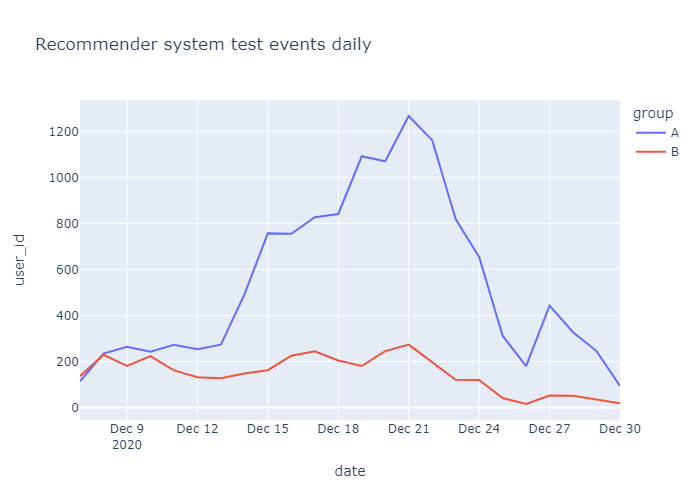

In [80]:
daily=recommender.groupby(['group','date'])['user_id'].count().reset_index()
fig = px.line(daily, x="date", y="user_id", color='group', title='Recommender system test events daily')
fig.show('png')

We can see that users are distributed unevenly between the groups (with number of users in group B significantly lower than number of users in group A), while number of events per user is not so different.

Let's look at distribution of events in interface testing to compare dynamics:

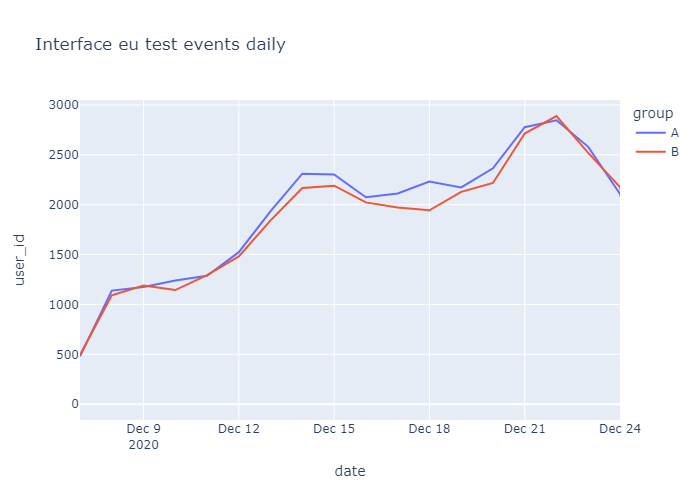

In [81]:
daily=interface.groupby(['group','date'])['user_id'].count().reset_index()
fig = px.line(daily, x="date", y="user_id", color='group', title='Interface eu test events daily')
fig.update_xaxes(range=list(['2020-12-07','2020-12-24']))
fig.show('png')

It looks like there was a problem with recruitment of users to the group B of recommender system test.

### Funnels and conversion rates

Let's study conversion at different funnel stages:

In [82]:
group_a=(recommender.query('group == "A"').groupby('event_name')['user_id'].nunique()
         .reset_index())
group_a

,event_name,user_id
0,login,1939
1,product_cart,589
2,product_page,1265
3,purchase,613


The number of users at purchase stage is greater than number of users at product_cart stage. Probably users can make a purchase without visiting product cart.

In [83]:
group_a=group_a.reindex([0,2,1,3])
group_a['%_by_stage']=100+round(group_a['user_id'].pct_change()*100)
group_a

,event_name,user_id,%_by_stage
0,login,1939,NaN
2,product_page,1265,65.0
1,product_cart,589,47.0
3,purchase,613,104.0


In [84]:
group_b=(recommender.query('group == "B"').groupby('event_name')['user_id'].nunique()
         .reset_index())
group_b

,event_name,user_id
0,login,654
1,product_cart,184
2,product_page,367
3,purchase,191


In [85]:
group_b=group_b.reindex([0,2,1,3])
group_b['%_by_stage']=100+round(group_b['user_id'].pct_change()*100)
group_b

,event_name,user_id,%_by_stage
0,login,654,NaN
2,product_page,367,56.0
1,product_cart,184,50.0
3,purchase,191,104.0


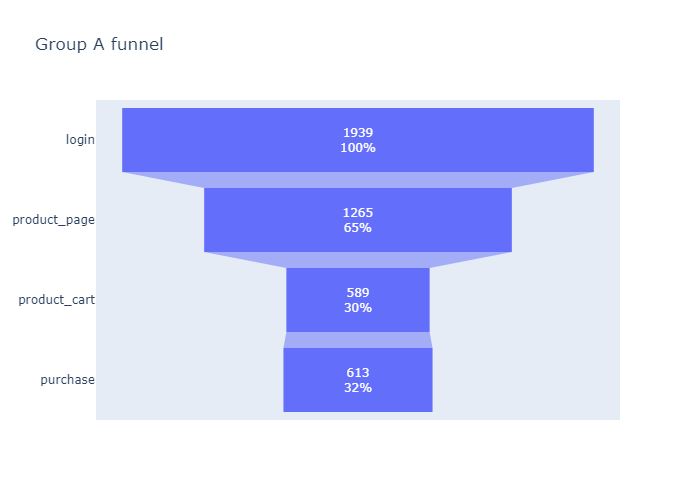

In [86]:
fig = go.Figure(go.Funnel(
    y = group_a['event_name'],
    x = group_a['user_id'],
    textposition = "inside",
    textinfo = "value+percent initial"))   

fig.update_layout(title='Group A funnel')
fig.show('png')

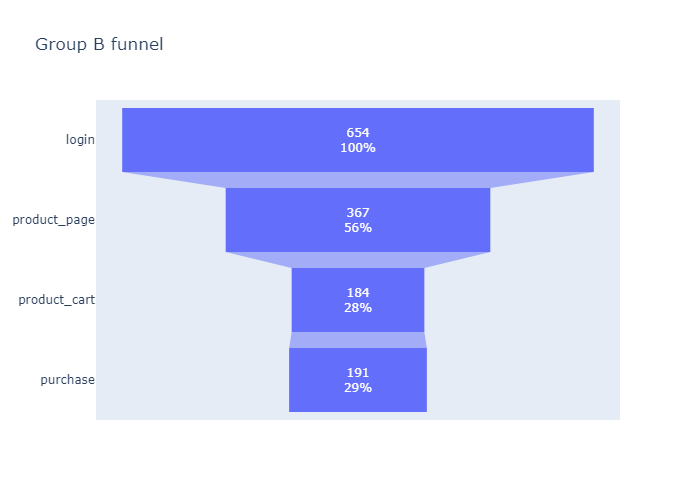

In [87]:
fig = go.Figure(go.Funnel(
    y = group_b['event_name'],
    x = group_b['user_id'],
    textposition = "inside",
    textinfo = "value+percent initial"))   

fig.update_layout(title='Group B funnel')
fig.show('png')

- Conversion from login to product page for group B is lower than for group A (56% vs 65%).
- Conversion from login to product cart for group B is lower than for group A (28% vs 30%).
- Conversion from login to purchase for group B is lower than for group A (29% vs 32%)

Expected result at least a 10% increase at each of the stage of the funnel product_page → product_card → purchase is not achieved.

### Evaluation of test results statistical significance

Let's use the z-criterion to check the statistical difference between the proportions.

The null hypothesis (H0) for the test is that the proportions are the same.
The alternate hypothesis (H1) is that the proportions are not the same.

In [88]:
def check_hypothesis(successes_A,  trials_A, successes_B, trials_B, alpha):
    p1 = successes_A/trials_A
    p2 = successes_B/trials_B
    p_combined = (successes_A + successes_B) / (trials_A + trials_B)
  
    difference = p1 - p2
   
    z_value = difference / math.sqrt(p_combined * (1 - p_combined) * (1/trials_A + 1/trials_B))
 
    distr = stats.norm(0, 1) 

    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('p-value: ', p_value)
    
    if p_value<alpha:
        print('Reject H0')
    else:
        print('Fail to Reject H0')

I set alpha at 0.05.

But as I am going to perform several statistical tests simultaneously on a single data set, I will make the Bonferroni correction in order to reduce the chances of obtaining false-positive results (type I errors) and divide the critical alpha by the number of comparisons being made (alpha = 0.05/3).

In [89]:
print('Evaluating hypothesis for login to product cart conversion:')
check_hypothesis(group_a.loc[1,'user_id'], group_a.loc[0,'user_id'], 
                 group_b.loc[1,'user_id'], group_b.loc[0,'user_id'], 
                 0.05/3)

Evaluating hypothesis for login to product cart conversion:
p-value:  0.2784249853300258
Fail to Reject H0


In [90]:
print('Evaluating hypothesis for login to product page conversion:')
check_hypothesis(group_a.loc[2,'user_id'], group_a.loc[0,'user_id'], 
                 group_b.loc[2,'user_id'], group_b.loc[0,'user_id'], 
                 0.05/3)

Evaluating hypothesis for login to product page conversion:
p-value:  2.9463911899618722e-05
Reject H0


In [91]:
print('Evaluating hypothesis for login to purchase conversion:')
check_hypothesis(group_a.loc[3,'user_id'], group_a.loc[0,'user_id'], 
                 group_b.loc[3,'user_id'], group_b.loc[0,'user_id'], 
                 0.05/3)

Evaluating hypothesis for login to purchase conversion:
p-value:  0.24933015751802245
Fail to Reject H0


We can conclude, that:
- for login to product page conversion for groups A and B we reject the Null hypothesis, that the proportions are statistically the same.
- for login to product cart and login to purchase conversion for groups A and B we can't reject the Null hypothesis, that the proportions are statistically the same.

## Possible details in the data that should be taked into account before starting the A/B test

Proper design of the test:
- Select the variable for testing
- Formulate the hypothesis to test 
- Determine sample size 
- Determine the duration of test
- Split control and test groups equally and randomly

Timing to conduct testing:
- Full business cycle
- Minimize seasonal / day of week influence
- No overlaps with other tests for the same participants

## Conclusion

Based on evaluation of results of A/B testing Group B didn't achieved expected result of test:

*Within 14 days of signing up, users will show better conversion into product page views (the product_page event), product card views (product_card) and purchases (purchase). At each of the stage of the funnel product_page → product_card → purchase, there will be at least a 10% increase.*

However, we can not conclude on the results of this test since we identified a number of issues in data provided for evaluation, which undermines the results of testing, including:

- The testing period (7 December to 1 January) is most likely affected by seasonality (Christmas and New Year holidays). Users behavior could be different in other periods.
- According to technical description, audience of the test is 15% of the new users from the EU region. Share of new users form the EU region included in the recommender system test was lower (8%).
- Expected number of participants (6000) was not reached (actual number of participants was 3675). 
- Number of participants in A and B groups in recommender system test is significantly uneven: number of B group participants is approximately 1/3 of number of A group participants. A technical issue with recruitment of users to the group B could cause this difference.